# Pemodelan IDS dengan Dataset CIC-IDS2017 (Journal-Based Preprocessing)

**Referensi**: "Uncertainty-Aware Adaptive Intrusion Detection Using Hybrid CNN-LSTM with cWGAN-GP Augmentation and Human-in-the-Loop Feedback" (Safety 2025, 11, 120)

**Notebook ini menggunakan hasil preprocessing dari `preprocess_journal_based.ipynb`**

**Pipeline Pemodelan**:
1. Load data dari artifacts preprocessing
2. Review karakteristik data
3. Hyperparameter search (tanpa split ratio)
4. Cross-validation k-fold
5. Training final model
6. Evaluasi pada test set
7. Visualisasi hasil
8. Simpan artifacts untuk inference


## 1. Setup Environment dan Import Libraries


In [5]:
import os
import time
import json
import joblib
import pickle
import gc
from pathlib import Path
import numpy as np
import random
import torch
import torch.nn as nn
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_curve
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ARTIFACTS_DIR = Path('./artifacts_journal_based')
MODEL_DIR = Path('./artifacts_modeling')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
        except RuntimeError:
            pass

clear_memory()


Device: cuda


## 2. Load Data dari Artifacts Preprocessing


In [6]:
print("="*80)
print("LOAD DATA DARI ARTIFACTS PREPROCESSING")
print("="*80)

train_data = joblib.load(ARTIFACTS_DIR / 'train_processed.pkl')
val_data = joblib.load(ARTIFACTS_DIR / 'val_processed.pkl')
test_data = joblib.load(ARTIFACTS_DIR / 'test_processed.pkl')

with open(ARTIFACTS_DIR / 'feature_cols.json', 'r') as f:
    feature_cols = json.load(f)

with open(ARTIFACTS_DIR / 'label_map.json', 'r') as f:
    label_map_data = json.load(f)
    label_map = label_map_data['label_map']
    inv_label_map = {int(k): v for k, v in label_map_data['inv_label_map'].items()}

transform_meta = joblib.load(ARTIFACTS_DIR / 'transform_meta.pkl')

print(f"\nData loaded:")
print(f"  Train: {len(train_data):,} rows")
print(f"  Validation: {len(val_data):,} rows")
print(f"  Test: {len(test_data):,} rows")
print(f"  Features: {len(feature_cols)}")
print(f"  Classes: {len(label_map)}")

print(f"\nFeature columns: {feature_cols}")
print(f"\nLabel map: {label_map}")

print(f"\nTransform meta keys: {list(transform_meta.keys()) if isinstance(transform_meta, dict) else 'Not a dict'}")

qt = transform_meta.get('quantile_transformer')
mm_scaler = transform_meta.get('minmax_scaler')

if qt is None or mm_scaler is None:
    print("\nWARNING: Transformers tidak ditemukan di transform_meta!")
    print("Test set tidak bisa di-transform. Periksa preprocessing.")
else:
    print("\nTransformers loaded successfully")


LOAD DATA DARI ARTIFACTS PREPROCESSING

Data loaded:
  Train: 1,390,343 rows
  Validation: 297,931 rows
  Test: 360,210 rows
  Features: 10
  Classes: 5

Feature columns: ['max_packet_length', 'average_packet_size', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'init_win_bytes_backward', 'packet_length_variance', 'total_length_of_fwd_packets', 'bwd_packet_length_max', 'active_mean', 'bwd_packet_length_min']

Label map: {'BENIGN': 0, 'Brute Force': 1, 'DDoS': 2, 'DoS': 3, 'Port Scan': 4}

Transform meta keys: ['quantile_transformer', 'minmax_scaler', 'feature_cols', 'fit_on', 'n_fit_samples', 'feature_cols_fitted']

Transformers loaded successfully


## 3. Review Karakteristik Data


REVIEW KARAKTERISTIK DATA

CRITICAL: Transform test set sebelum digunakan!
Train data sudah di-transform (range: [0.00, 1.00])
Test data perlu di-transform menggunakan transformers dari preprocessing
Test data columns: 45 features (harus 45)
Transform feature cols: 45 features


Test data raw range: [-6442447872.00, 2071000064.00]

Transforming test set dengan 45 features...


/home/alfan/miniconda/envs/pemodel-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Test data transformed range: [-0.00, 1.00]
Selected 10 features dari 45 features
Train and test now in same scale: True

1. DIMENSI DATA:
   Train: (1390343, 10)
   Validation: (297931, 10)
   Test: (360210, 10)

2. DISTRIBUSI KELAS:

   Train:
     BENIGN (ID 0): 1,190,956 (85.66%)
     Brute Force (ID 1): 6,464 (0.46%)
     DDoS (ID 2): 76,171 (5.48%)
     DoS (ID 3): 115,488 (8.31%)
     Port Scan (ID 4): 1,264 (0.09%)

   Validation:
     BENIGN (ID 0): 255,205 (85.66%)
     Brute Force (ID 1): 1,385 (0.46%)
     DDoS (ID 2): 16,323 (5.48%)
     DoS (ID 3): 24,747 (8.31%)
     Port Scan (ID 4): 271 (0.09%)

   Test:
     BENIGN (ID 0): 289,592 (80.40%)
     Brute Force (ID 1): 1,956 (0.54%)
     DDoS (ID 2): 16,323 (4.53%)
     DoS (ID 3): 32,092 (8.91%)
     Port Scan (ID 4): 20,247 (5.62%)

3. STATISTIK FEATURES:
       max_packet_length  average_packet_size  total_length_of_bwd_packets  \
count       1.390343e+06         1.390343e+06                 1.390343e+06   
mean        4

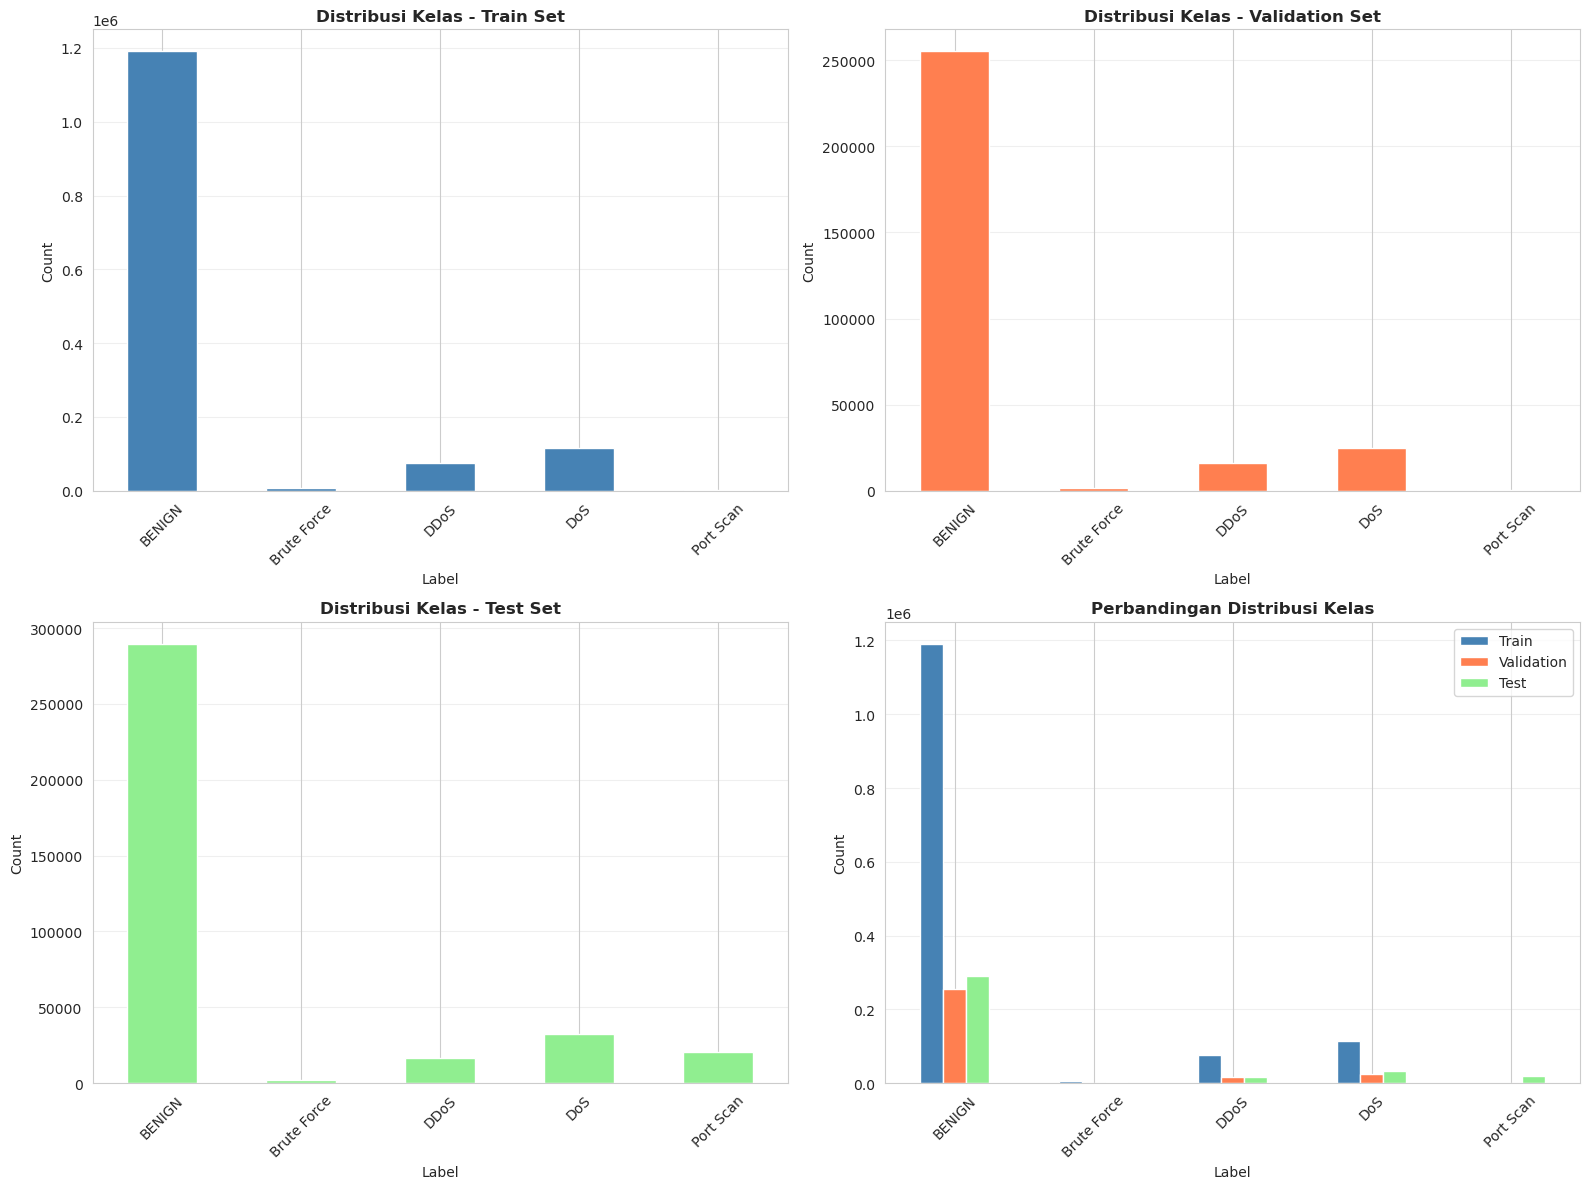


Visualisasi disimpan ke: artifacts_modeling/data_review.png

DATA BALANCING - STRATEGI HANDLING CLASS IMBALANCE

PENTING: Pertimbangan Risiko SMOTE
1. RISIKO SMOTE:
   - Synthetic samples bisa membuat model overfit pada pola sintetik
   - Model mungkin terlalu optimis pada training tapi gagal pada data baru
   - Perlu validasi ketat (monitor train vs validation gap)

2. MITIGASI YANG DITERAPKAN:
   - SMOTE HANYA pada training set (TIDAK pada validation/test)
   - Oversampling moderat (40% dari majority, bukan full balance)
   - Kombinasi dengan class weights + Focal Loss (bukan hanya SMOTE)
   - Cross-validation untuk evaluasi yang robust
   - Early stopping untuk mencegah overfitting

3. REKOMENDASI:
   - Opsi 1 (LEBIH AMAN): Hanya class weights + Focal Loss (USE_SMOTE=False)
   - Opsi 2: SMOTE moderat + monitoring ketat (USE_SMOTE=True)
   - Jika gap train-val > 10%, pertimbangkan kurangi SMOTE atau nonaktifkan

Konfigurasi saat ini:
  USE_SMOTE: False (False = lebih aman, True = le

In [7]:
print("="*80)
print("REVIEW KARAKTERISTIK DATA")
print("="*80)

X_train = train_data[feature_cols].values.astype(np.float32)
y_train = train_data['label_encoded'].values
X_val = val_data[feature_cols].values.astype(np.float32)
y_val = val_data['label_encoded'].values

print(f"\nCRITICAL: Transform test set sebelum digunakan!")
print(f"Train data sudah di-transform (range: [{X_train.min():.2f}, {X_train.max():.2f}])")
print(f"Test data perlu di-transform menggunakan transformers dari preprocessing")

# Test set disimpan dengan 45 features (BELUM di-transform, sebelum feature selection)
# Kita perlu transform dengan 45 features, lalu select 10 features
test_feature_cols_all = [c for c in test_data.columns if c not in ['label_collapsed', 'label_encoded']]
print(f"Test data columns: {len(test_feature_cols_all)} features (harus 45)")

# Pastikan urutan feature sama dengan yang digunakan saat fit transformer
# feature_cols dari transform_meta adalah 45 features yang digunakan saat fit
transform_feature_cols = transform_meta.get('feature_cols', test_feature_cols_all)
print(f"Transform feature cols: {len(transform_feature_cols)} features")

X_test_raw = test_data[transform_feature_cols].values.astype(np.float32)
print(f"Test data raw range: [{X_test_raw.min():.2f}, {X_test_raw.max():.2f}]")

if qt is not None and mm_scaler is not None:
    print(f"\nTransforming test set dengan {len(transform_feature_cols)} features...")
    X_test_qt = qt.transform(X_test_raw)
    X_test_scaled = mm_scaler.transform(X_test_qt).astype(np.float32)
    
    # Select hanya 10 features yang sama dengan train/val
    feature_cols_idx = [transform_feature_cols.index(f) for f in feature_cols if f in transform_feature_cols]
    X_test = X_test_scaled[:, feature_cols_idx]
    
    print(f"Test data transformed range: [{X_test.min():.2f}, {X_test.max():.2f}]")
    print(f"Selected {len(feature_cols)} features dari {len(transform_feature_cols)} features")
    print(f"Train and test now in same scale: {np.allclose(X_train.min(), X_test.min(), atol=0.1) and np.allclose(X_train.max(), X_test.max(), atol=0.1)}")
else:
    print("\nERROR: Cannot transform test set - transformers not available!")
    print("Using raw test data (WILL CAUSE POOR PERFORMANCE)")
    if 'feature_cols_idx' in locals():
        X_test = X_test_raw[:, feature_cols_idx]
    else:
        X_test = test_data[feature_cols].values.astype(np.float32)

y_test = test_data['label_encoded'].values

print(f"\n1. DIMENSI DATA:")
print(f"   Train: {X_train.shape}")
print(f"   Validation: {X_val.shape}")
print(f"   Test: {X_test.shape}")

print(f"\n2. DISTRIBUSI KELAS:")
train_dist = pd.Series(y_train).value_counts().sort_index()
val_dist = pd.Series(y_val).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print(f"\n   Train:")
for label_id, count in train_dist.items():
    label_name = inv_label_map[label_id]
    pct = count / len(y_train) * 100
    print(f"     {label_name} (ID {label_id}): {count:,} ({pct:.2f}%)")

print(f"\n   Validation:")
for label_id, count in val_dist.items():
    label_name = inv_label_map[label_id]
    pct = count / len(y_val) * 100
    print(f"     {label_name} (ID {label_id}): {count:,} ({pct:.2f}%)")

print(f"\n   Test:")
for label_id, count in test_dist.items():
    label_name = inv_label_map[label_id]
    pct = count / len(y_test) * 100
    print(f"     {label_name} (ID {label_id}): {count:,} ({pct:.2f}%)")

print(f"\n3. STATISTIK FEATURES:")
feature_stats = pd.DataFrame(X_train, columns=feature_cols).describe()
print(feature_stats)

print(f"\n4. CLASS IMBALANCE RATIO:")
max_class = train_dist.max()
min_class = train_dist.min()
imbalance_ratio = max_class / min_class
print(f"   Ratio (max/min): {imbalance_ratio:.2f}x")
print(f"   Ini menunjukkan class imbalance yang signifikan")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

train_dist_plot = train_dist.copy()
train_dist_plot.index = [inv_label_map[i] for i in train_dist_plot.index]
train_dist_plot.plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Distribusi Kelas - Train Set', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Label')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

val_dist_plot = val_dist.copy()
val_dist_plot.index = [inv_label_map[i] for i in val_dist_plot.index]
val_dist_plot.plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Distribusi Kelas - Validation Set', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Label')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

test_dist_plot = test_dist.copy()
test_dist_plot.index = [inv_label_map[i] for i in test_dist_plot.index]
test_dist_plot.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribusi Kelas - Test Set', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Label')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

comparison_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0)
comparison_df.index = [inv_label_map[i] for i in comparison_df.index]
comparison_df.plot(kind='bar', ax=axes[1, 1], color=['steelblue', 'coral', 'lightgreen'])
axes[1, 1].set_title('Perbandingan Distribusi Kelas', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Label')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'data_review.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {MODEL_DIR / 'data_review.png'}")

print("\n" + "="*80)
print("DATA BALANCING - STRATEGI HANDLING CLASS IMBALANCE")
print("="*80)

print("\nPENTING: Pertimbangan Risiko SMOTE")
print("="*80)
print("1. RISIKO SMOTE:")
print("   - Synthetic samples bisa membuat model overfit pada pola sintetik")
print("   - Model mungkin terlalu optimis pada training tapi gagal pada data baru")
print("   - Perlu validasi ketat (monitor train vs validation gap)")
print("\n2. MITIGASI YANG DITERAPKAN:")
print("   - SMOTE HANYA pada training set (TIDAK pada validation/test)")
print("   - Oversampling moderat (40% dari majority, bukan full balance)")
print("   - Kombinasi dengan class weights + Focal Loss (bukan hanya SMOTE)")
print("   - Cross-validation untuk evaluasi yang robust")
print("   - Early stopping untuk mencegah overfitting")
print("\n3. REKOMENDASI:")
print("   - Opsi 1 (LEBIH AMAN): Hanya class weights + Focal Loss (USE_SMOTE=False)")
print("   - Opsi 2: SMOTE moderat + monitoring ketat (USE_SMOTE=True)")
print("   - Jika gap train-val > 10%, pertimbangkan kurangi SMOTE atau nonaktifkan")
print("="*80)

# REKOMENDASI: Mulai dengan False (lebih aman), aktifkan jika diperlukan
USE_SMOTE = False  # Default: False (lebih aman, gunakan class weights + Focal Loss saja)
USE_AGGRESSIVE_WEIGHTS = True
USE_FOCAL_LOSS = True

print(f"\nKonfigurasi saat ini:")
print(f"  USE_SMOTE: {USE_SMOTE} (False = lebih aman, True = lebih agresif)")
print(f"  USE_AGGRESSIVE_WEIGHTS: {USE_AGGRESSIVE_WEIGHTS}")
print(f"  USE_FOCAL_LOSS: {USE_FOCAL_LOSS}")
print(f"\nJika USE_SMOTE=False, model akan menggunakan:")
print(f"  - Class weights untuk menyeimbangkan loss function")
print(f"  - Focal Loss untuk fokus pada hard examples")
print(f"  - Strategi ini lebih aman dan tidak membuat synthetic data")

if USE_SMOTE:
    print("\nMenerapkan SMOTE untuk balancing data...")
    print(f"Sebelum SMOTE:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Class distribution:")
    train_dist_before = pd.Series(y_train).value_counts().sort_index()
    for label_id, count in train_dist_before.items():
        label_name = inv_label_map[label_id]
        pct = count / len(y_train) * 100
        print(f"    {label_name} (ID {label_id}): {count:,} ({pct:.2f}%)")
    
    # BEST PRACTICE: Adaptive oversampling strategy
    # 1. Gunakan rasio target (0.4 = 40% dari majority) untuk moderate minority
    # 2. Untuk extreme minority (<1%), gunakan multiplier yang lebih besar
    # 3. Untuk moderate minority (1-10%), gunakan multiplier sedang
    # 4. Pastikan minimum samples cukup untuk learning (min 10k-20k samples)
    
    majority_count = train_dist_before.max()
    target_ratio = 0.4  # Target 40% dari majority class (best practice: 30-50%)
    max_target = int(majority_count * target_ratio)
    min_samples = 20000  # Minimum samples untuk learning yang efektif
    
    sampling_strategy_dict = {}
    print(f"\nStrategi oversampling (target ratio: {target_ratio*100:.0f}% dari majority = {max_target:,}):")
    
    for label_id, count in train_dist_before.items():
        if count < majority_count:  # Hanya untuk minority classes
            pct = count / len(y_train) * 100
            
            # Adaptive multiplier berdasarkan proporsi kelas
            if pct < 0.5:  # Extreme minority (<0.5%)
                multiplier = 10  # Oversample lebih agresif
            elif pct < 2.0:  # Very minority (0.5-2%)
                multiplier = 5
            elif pct < 5.0:  # Moderate minority (2-5%)
                multiplier = 3
            else:  # Mild minority (5-10%)
                multiplier = 2
            
            # Target: min(multiplier x jumlah asli, target_ratio x majority, tapi minimal min_samples)
            target_by_multiplier = count * multiplier
            target_by_ratio = max_target
            
            # Gunakan yang lebih besar antara multiplier-based dan min_samples, tapi tidak melebihi ratio
            target = min(max(target_by_multiplier, min_samples), target_by_ratio)
            
            sampling_strategy_dict[label_id] = target
            print(f"    {inv_label_map[label_id]} (ID {label_id}): {count:,} ({pct:.2f}%) -> multiplier {multiplier}x -> target: {target:,}")
    
    print(f"\nMenerapkan SMOTE dengan strategi adaptif...")
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3, sampling_strategy=sampling_strategy_dict)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"\nSetelah SMOTE:")
    print(f"  Train shape: {X_train_balanced.shape}")
    print(f"  Class distribution:")
    train_dist_after = pd.Series(y_train_balanced).value_counts().sort_index()
    for label_id, count in train_dist_after.items():
        label_name = inv_label_map[label_id]
        pct = count / len(y_train_balanced) * 100
        print(f"    {label_name} (ID {label_id}): {count:,} ({pct:.2f}%)")
    
    X_train = X_train_balanced.astype(np.float32)
    y_train = y_train_balanced
    
    print(f"\nData sudah di-balance dengan SMOTE")
    print(f"Ukuran data training meningkat dari {len(train_dist_before)} menjadi {len(y_train)} samples")
else:
    print("\nSMOTE tidak digunakan (USE_SMOTE = False)")


## 4. Definisi Model dan Helper Functions

Mendefinisikan arsitektur model Deep Neural Network (DNN) dan fungsi-fungsi helper untuk training, prediction, dan evaluasi.

**Improvements yang diimplementasikan:**
- Class weights yang lebih agresif untuk extreme minority classes
- Focal Loss untuk fokus pada hard examples
- SMOTE/ADASYN untuk data balancing


In [8]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_classes, activation='relu', dropout=0.35):
        super(DNN, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(0.2))
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'elu':
                layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def compute_class_weight(y, num_classes=None):
    from sklearn.utils.class_weight import compute_class_weight as sk_compute_class_weight
    classes = np.arange(num_classes) if num_classes else np.unique(y)
    weights = sk_compute_class_weight('balanced', classes=classes, y=y)
    return torch.tensor(weights, dtype=torch.float32).to(device)

def compute_class_weight_aggressive(y, num_classes=None, min_weight=1.0, max_weight=50.0):
    from sklearn.utils.class_weight import compute_class_weight as sk_compute_class_weight
    classes = np.arange(num_classes) if num_classes else np.unique(y)
    
    weights = sk_compute_class_weight('balanced', classes=classes, y=y)
    
    class_counts = pd.Series(y).value_counts().sort_index()
    majority_count = class_counts.max()
    minority_threshold = majority_count / 100
    
    for i, count in enumerate(class_counts):
        if count < minority_threshold:
            weights[i] = min(weights[i] * 2.5, max_weight)
    
    weights = np.clip(weights, min_weight, max_weight)
    return torch.tensor(weights, dtype=torch.float32).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

def train_model(model, X_train, y_train, X_val, y_val, class_weights,
                lr=0.001, max_epochs=50, batch_size=128, patience=10, use_focal_loss=False, focal_gamma=2.0):
    model = model.to(device)
    if use_focal_loss:
        criterion = FocalLoss(alpha=class_weights, gamma=focal_gamma)
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    best_loss = float('inf')
    best_state = None
    wait = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for i in range(0, len(X_train), batch_size):
            xb = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32).to(device)
            yb = torch.tensor(y_train[i:i+batch_size], dtype=torch.long).to(device)
            
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            train_loss += loss.item() * len(xb)
            del xb, yb, logits
        
        avg_train_loss = train_loss / len(X_train)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                xv = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32).to(device)
                yv = torch.tensor(y_val[i:i+batch_size], dtype=torch.long).to(device)
                logits = model(xv)
                loss = criterion(logits, yv)
                val_loss += loss.item() * len(xv)
                del xv, yv, logits
        
        avg_val_loss = val_loss / len(X_val)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_loss - 1e-4:
            best_loss = avg_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{max_epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    
    if best_state is not None:
        model.load_state_dict(best_state)
    
    clear_memory()
    return model, train_losses, val_losses

def predict_batch(model, X, batch_size=4096):
    model.eval()
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)
            all_preds.append(preds)
            all_probs.append(probs)
            del xb, logits
    clear_memory()
    return np.concatenate(all_preds), np.vstack(all_probs)

def macro_f1_score(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return rep['macro avg']['f1-score'], rep

print("Model dan helper functions sudah didefinisikan")


Model dan helper functions sudah didefinisikan


## 5. Hyperparameter Search (Tanpa Split Ratio)

Mencari kombinasi hyperparameter terbaik menggunakan subset data training. Tidak melakukan pencarian split ratio karena data sudah di-split dengan benar dari preprocessing. Hyperparameter yang dicari meliputi: arsitektur layer, fungsi aktivasi, learning rate, batch size, dan jumlah epochs.


In [ ]:
print("="*80)
print("HYPERPARAMETER SEARCH (BATCH-BASED)")
print("="*80)

sample_size = min(100000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
    X_train_sample, y_train_sample, test_size=0.2, stratify=y_train_sample, random_state=RANDOM_STATE
)

num_classes = len(np.unique(y_train))
input_dim = X_train.shape[1]

print(f"Using sample: {len(X_train_hp):,} train, {len(X_val_hp):,} val")
print(f"Input dim: {input_dim}, Num classes: {num_classes}")

baseline_layers = [256, 128, 128]
baseline_activation = 'relu'
baseline_lr = 0.001
baseline_epochs = 40
baseline_batch_size = 128

print(f"\nBaseline configuration:")
print(f"  Layers: {baseline_layers}")
print(f"  Activation: {baseline_activation}")
print(f"  Learning Rate: {baseline_lr}")
print(f"  Epochs: {baseline_epochs}")
print(f"  Batch Size: {baseline_batch_size}")

X_train_batch, X_val_batch, y_train_batch, y_val_batch = train_test_split(
    X_train_hp, y_train_hp, test_size=0.2, stratify=y_train_hp, random_state=RANDOM_STATE
)

batch_results = {}

print("\n" + "="*50)
print("Batch 1: Hidden Layer Variants")
print("="*50)
layer_variants = [[256, 128, 128], [256, 256, 128], [256, 256, 128, 64], [512, 256, 128]]
batch1 = []
for layers in layer_variants:
    try:
        model = DNN(input_dim, layers, num_classes, activation=baseline_activation, dropout=0.35)
        class_weights = compute_class_weight(y_train_batch, num_classes)
        model, _, _ = train_model(
            model, X_train_batch, y_train_batch, X_val_batch, y_val_batch,
            class_weights, lr=baseline_lr, max_epochs=baseline_epochs, 
            batch_size=baseline_batch_size, patience=8
        )
        y_pred, _ = predict_batch(model, X_val_hp)
        mf1, _ = macro_f1_score(y_val_hp, y_pred)
        batch1.append({'layers': layers, 'macro_f1': mf1})
        print(f"  Layers {layers}: Macro F1 = {mf1:.4f}")
        del model
        clear_memory()
    except Exception as e:
        print(f"  Layers {layers} failed: {e}")
        clear_memory()

batch1_df = pd.DataFrame(batch1) if batch1 else pd.DataFrame()
if not batch1_df.empty:
    best_layers = batch1_df.sort_values('macro_f1', ascending=False).iloc[0]['layers']
else:
    best_layers = baseline_layers
    batch1_df = pd.DataFrame([{'layers': baseline_layers, 'macro_f1': 0.0}])
print(f"\nBest layers: {best_layers}")

print("\n" + "="*50)
print("Batch 2: Activation Variants")
print("="*50)
activation_variants = ['relu', 'leaky_relu', 'tanh', 'elu']
batch2 = []
for activation in activation_variants:
    try:
        model = DNN(input_dim, best_layers, num_classes, activation=activation, dropout=0.35)
        class_weights = compute_class_weight(y_train_batch, num_classes)
        model, _, _ = train_model(
            model, X_train_batch, y_train_batch, X_val_batch, y_val_batch,
            class_weights, lr=baseline_lr, max_epochs=baseline_epochs,
            batch_size=baseline_batch_size, patience=8
        )
        y_pred, _ = predict_batch(model, X_val_hp)
        mf1, _ = macro_f1_score(y_val_hp, y_pred)
        batch2.append({'activation': activation, 'macro_f1': mf1})
        print(f"  Activation {activation}: Macro F1 = {mf1:.4f}")
        del model
        clear_memory()
    except Exception as e:
        print(f"  Activation {activation} failed: {e}")
        clear_memory()

batch2_df = pd.DataFrame(batch2) if batch2 else pd.DataFrame()
if not batch2_df.empty:
    best_activation = batch2_df.sort_values('macro_f1', ascending=False).iloc[0]['activation']
else:
    best_activation = baseline_activation
    batch2_df = pd.DataFrame([{'activation': baseline_activation, 'macro_f1': 0.0}])
print(f"\nBest activation: {best_activation}")

print("\n" + "="*50)
print("Batch 3: Learning Rate Variants")
print("="*50)
lr_variants = [0.001, 0.0005, 0.0001]
batch3 = []
for lr in lr_variants:
    try:
        model = DNN(input_dim, best_layers, num_classes, activation=best_activation, dropout=0.35)
        class_weights = compute_class_weight(y_train_batch, num_classes)
        model, _, _ = train_model(
            model, X_train_batch, y_train_batch, X_val_batch, y_val_batch,
            class_weights, lr=lr, max_epochs=baseline_epochs,
            batch_size=baseline_batch_size, patience=8
        )
        y_pred, _ = predict_batch(model, X_val_hp)
        mf1, _ = macro_f1_score(y_val_hp, y_pred)
        batch3.append({'lr': lr, 'macro_f1': mf1})
        print(f"  LR {lr}: Macro F1 = {mf1:.4f}")
        del model
        clear_memory()
    except Exception as e:
        print(f"  LR {lr} failed: {e}")
        clear_memory()

batch3_df = pd.DataFrame(batch3) if batch3 else pd.DataFrame()
if not batch3_df.empty:
    best_lr = float(batch3_df.sort_values('macro_f1', ascending=False).iloc[0]['lr'])
else:
    best_lr = baseline_lr
    batch3_df = pd.DataFrame([{'lr': baseline_lr, 'macro_f1': 0.0}])
print(f"\nBest learning rate: {best_lr}")

print("\n" + "="*50)
print("Batch 4: Epoch Variants")
print("="*50)
epoch_variants = [40, 60, 80]
batch4 = []
for epochs in epoch_variants:
    try:
        model = DNN(input_dim, best_layers, num_classes, activation=best_activation, dropout=0.35)
        class_weights = compute_class_weight(y_train_batch, num_classes)
        model, _, _ = train_model(
            model, X_train_batch, y_train_batch, X_val_batch, y_val_batch,
            class_weights, lr=best_lr, max_epochs=epochs,
            batch_size=baseline_batch_size, patience=max(6, int(epochs/4))
        )
        y_pred, _ = predict_batch(model, X_val_hp)
        mf1, _ = macro_f1_score(y_val_hp, y_pred)
        batch4.append({'epochs': epochs, 'macro_f1': mf1})
        print(f"  Epochs {epochs}: Macro F1 = {mf1:.4f}")
        del model
        clear_memory()
    except Exception as e:
        print(f"  Epochs {epochs} failed: {e}")
        clear_memory()

batch4_df = pd.DataFrame(batch4) if batch4 else pd.DataFrame()
if not batch4_df.empty:
    best_epochs = int(batch4_df.sort_values('macro_f1', ascending=False).iloc[0]['epochs'])
else:
    best_epochs = baseline_epochs
    batch4_df = pd.DataFrame([{'epochs': baseline_epochs, 'macro_f1': 0.0}])
print(f"\nBest epochs: {best_epochs}")

print("\n" + "="*50)
print("Batch 5: Batch Size Variants")
print("="*50)
batch_size_variants = [64, 128, 256]
batch5 = []
for batch_size in batch_size_variants:
    try:
        model = DNN(input_dim, best_layers, num_classes, activation=best_activation, dropout=0.35)
        class_weights = compute_class_weight(y_train_batch, num_classes)
        model, _, _ = train_model(
            model, X_train_batch, y_train_batch, X_val_batch, y_val_batch,
            class_weights, lr=best_lr, max_epochs=best_epochs,
            batch_size=batch_size, patience=max(6, int(best_epochs/4))
        )
        y_pred, _ = predict_batch(model, X_val_hp)
        mf1, _ = macro_f1_score(y_val_hp, y_pred)
        batch5.append({'batch_size': batch_size, 'macro_f1': mf1})
        print(f"  Batch size {batch_size}: Macro F1 = {mf1:.4f}")
        del model
        clear_memory()
    except Exception as e:
        print(f"  Batch size {batch_size} failed: {e}")
        clear_memory()

batch5_df = pd.DataFrame(batch5) if batch5 else pd.DataFrame()
if not batch5_df.empty:
    best_batch_size = int(batch5_df.sort_values('macro_f1', ascending=False).iloc[0]['batch_size'])
else:
    best_batch_size = baseline_batch_size
    batch5_df = pd.DataFrame([{'batch_size': baseline_batch_size, 'macro_f1': 0.0}])
print(f"\nBest batch size: {best_batch_size}")

best_config = {
    'layers': best_layers,
    'activation': best_activation,
    'lr': best_lr,
    'epochs': best_epochs,
    'batch_size': best_batch_size
}

print("\n" + "="*50)
print("HYPERPARAMETER SEARCH SUMMARY")
print("="*50)
print(f"Best configuration:")
print(f"  Layers: {best_config['layers']}")
print(f"  Activation: {best_config['activation']}")
print(f"  Learning Rate: {best_config['lr']}")
print(f"  Epochs: {best_config['epochs']}")
print(f"  Batch Size: {best_config['batch_size']}")

phaseA_summary = {
    'batch1_layers': batch1_df,
    'batch2_activation': batch2_df,
    'batch3_lr': batch3_df,
    'batch4_epochs': batch4_df,
    'batch5_batch_size': batch5_df,
    'final_config': best_config
}

joblib.dump(best_config, MODEL_DIR / 'best_hyperparameters.pkl')
joblib.dump(phaseA_summary, MODEL_DIR / 'hyperparameter_search_batches.pkl')

if not batch1_df.empty:
    batch1_df.to_csv(MODEL_DIR / 'batch1_layers_results.csv', index=False)
if not batch2_df.empty:
    batch2_df.to_csv(MODEL_DIR / 'batch2_activation_results.csv', index=False)
if not batch3_df.empty:
    batch3_df.to_csv(MODEL_DIR / 'batch3_lr_results.csv', index=False)
if not batch4_df.empty:
    batch4_df.to_csv(MODEL_DIR / 'batch4_epochs_results.csv', index=False)
if not batch5_df.empty:
    batch5_df.to_csv(MODEL_DIR / 'batch5_batch_size_results.csv', index=False)

print(f"\nResults saved to {MODEL_DIR}")


HYPERPARAMETER SEARCH (BATCH-BASED)
Using sample: 80,000 train, 20,000 val
Input dim: 10, Num classes: 5

Baseline configuration:
  Layers: [256, 128, 128]
  Activation: relu
  Learning Rate: 0.001
  Epochs: 40
  Batch Size: 128

Batch 1: Hidden Layer Variants


VISUALISASI PERKEMBANGAN MACRO F1 PADA SETIAP BATCH EKSPLORASI

Grafik berhasil disimpan: artifacts_modeling/eksplorasi_hyperparameter.png

Nilai optimal per batch:
  1. Batch 1
(Layers): 0.5784
  2. Batch 2
(Activation): 0.5952
  3. Batch 3
(Learning Rate): 0.5482
  4. Batch 4
(Epochs): 0.5926
  5. Batch 5
(Batch Size): 0.5933


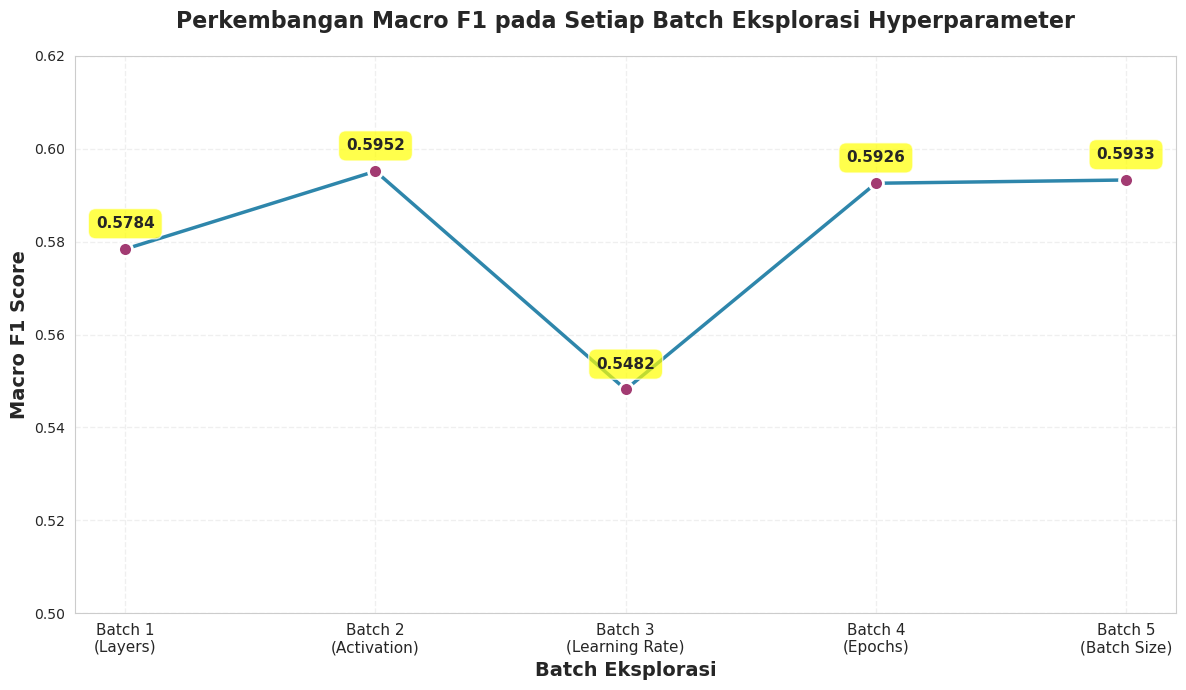

In [ ]:
# Visualisasi Perkembangan Macro F1 pada Setiap Batch Eksplorasi
print("="*80)
print("VISUALISASI PERKEMBANGAN MACRO F1 PADA SETIAP BATCH EKSPLORASI")
print("="*80)

# Load data dari CSV files
batch1_df = pd.read_csv(MODEL_DIR / 'batch1_layers_results.csv')
batch2_df = pd.read_csv(MODEL_DIR / 'batch2_activation_results.csv')
batch3_df = pd.read_csv(MODEL_DIR / 'batch3_lr_results.csv')
batch4_df = pd.read_csv(MODEL_DIR / 'batch4_epochs_results.csv')
batch5_df = pd.read_csv(MODEL_DIR / 'batch5_batch_size_results.csv')

# Ambil nilai optimal untuk setiap batch
optimal_values = [
    batch1_df['macro_f1'].max(),  # Batch 1: Layers
    batch2_df['macro_f1'].max(),  # Batch 2: Activation
    batch3_df['macro_f1'].max(),  # Batch 3: Learning Rate
    batch4_df['macro_f1'].max(),  # Batch 4: Epochs
    batch5_df['macro_f1'].max()   # Batch 5: Batch Size
]

# Label batch
batch_labels = ['Batch 1\n(Layers)', 'Batch 2\n(Activation)', 'Batch 3\n(Learning Rate)', 
                'Batch 4\n(Epochs)', 'Batch 5\n(Batch Size)']

# Buat figure dengan ukuran yang sesuai untuk jurnal
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(range(1, 6), optimal_values, marker='o', linewidth=2.5, markersize=10, 
         color='#2E86AB', markerfacecolor='#A23B72', markeredgewidth=2, markeredgecolor='white')

# Tambahkan nilai di setiap titik
for i, (batch, value) in enumerate(zip(batch_labels, optimal_values)):
    ax.annotate(f'{value:.4f}', 
                xy=(i+1, value), 
                xytext=(0, 15), 
                textcoords='offset points',
                ha='center', 
                fontsize=11, 
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Styling
ax.set_xlabel('Batch Eksplorasi', fontsize=14, fontweight='bold')
ax.set_ylabel('Macro F1 Score', fontsize=14, fontweight='bold')
ax.set_title('Perkembangan Macro F1 pada Setiap Batch Eksplorasi Hyperparameter', 
          fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(1, 6))
ax.set_xticklabels(batch_labels, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.set_ylim([0.50, 0.62])
plt.tight_layout()

# Simpan dengan resolusi tinggi
output_file = MODEL_DIR / 'eksplorasi_hyperparameter.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f'\nGrafik berhasil disimpan: {output_file}')
print(f'\nNilai optimal per batch:')
for i, (label, value) in enumerate(zip(batch_labels, optimal_values), 1):
    print(f'  {i}. {label.strip()}: {value:.4f}')

plt.show()



## 6. Cross-Validation K-Fold

Menggunakan k-fold cross-validation untuk validasi yang lebih robust menggunakan konfigurasi hyperparameter terbaik.


In [ ]:
print("="*80)
print("CROSS-VALIDATION K-FOLD")
print("="*80)

if 'best_config' not in globals() or best_config is None:
    print("Warning: best_config not found. Using baseline configuration.")
    best_config = {
        'layers': [256, 128, 128],
        'activation': 'relu',
        'lr': 0.001,
        'epochs': 40,
        'batch_size': 128
    }

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
fold = 0

for train_idx, val_idx in skf.split(X_train, y_train):
    fold += 1
    print(f"\nFold {fold}/{k_folds}:")
    
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    model = DNN(input_dim, best_config['layers'], num_classes,
                 activation=best_config['activation'], dropout=0.35)
    if 'USE_AGGRESSIVE_WEIGHTS' in globals() and USE_AGGRESSIVE_WEIGHTS:
        class_weights = compute_class_weight_aggressive(y_train_fold, num_classes)
    else:
        class_weights = compute_class_weight(y_train_fold, num_classes)
    
    use_fl = 'USE_FOCAL_LOSS' in globals() and USE_FOCAL_LOSS
    model, train_losses, val_losses = train_model(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        class_weights, lr=best_config['lr'], max_epochs=best_config['epochs'],
        batch_size=best_config['batch_size'], patience=10,
        use_focal_loss=use_fl, focal_gamma=2.0
    )
    
    y_pred, _ = predict_batch(model, X_val_fold)
    mf1, rep = macro_f1_score(y_val_fold, y_pred)
    acc = accuracy_score(y_val_fold, y_pred)
    
    cv_results.append({
        'fold': fold,
        'macro_f1': mf1,
        'accuracy': acc,
        'train_losses': train_losses,
        'val_losses': val_losses
    })
    
    print(f"  Macro F1: {mf1:.4f}, Accuracy: {acc:.4f}")
    del model
    clear_memory()

cv_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['train_losses', 'val_losses']} for r in cv_results])
mean_mf1 = cv_df['macro_f1'].mean()
std_mf1 = cv_df['macro_f1'].std()
mean_acc = cv_df['accuracy'].mean()
std_acc = cv_df['accuracy'].std()

print(f"\nCV Results Summary:")
print(f"  Macro F1: {mean_mf1:.4f} (+/- {std_mf1:.4f})")
print(f"  Accuracy: {mean_acc:.4f} (+/- {std_acc:.4f})")

cv_df.to_csv(MODEL_DIR / 'cv_results.csv', index=False)
joblib.dump(cv_results, MODEL_DIR / 'cv_results_full.pkl')


CROSS-VALIDATION K-FOLD



Fold 1/5:
  Epoch 10/60: Train Loss=0.2030, Val Loss=0.1568
  Epoch 20/60: Train Loss=0.1881, Val Loss=0.1602
  Epoch 30/60: Train Loss=0.1822, Val Loss=0.1393
  Macro F1: 0.7795, Accuracy: 0.9830

Fold 2/5:
  Epoch 10/60: Train Loss=0.2002, Val Loss=0.1834
  Epoch 20/60: Train Loss=0.1872, Val Loss=0.1537
  Epoch 30/60: Train Loss=0.1801, Val Loss=0.1481
  Epoch 40/60: Train Loss=0.1837, Val Loss=0.1340
  Macro F1: 0.7836, Accuracy: 0.9856

Fold 3/5:
  Epoch 10/60: Train Loss=0.1950, Val Loss=0.1828
  Epoch 20/60: Train Loss=0.1857, Val Loss=0.1633
  Epoch 30/60: Train Loss=0.1823, Val Loss=0.1482
  Epoch 40/60: Train Loss=0.1838, Val Loss=0.1425
  Epoch 50/60: Train Loss=0.1797, Val Loss=0.1468
  Epoch 60/60: Train Loss=0.1778, Val Loss=0.1407
  Macro F1: 0.7849, Accuracy: 0.9832

Fold 4/5:
  Epoch 10/60: Train Loss=0.2023, Val Loss=0.1752
  Epoch 20/60: Train Loss=0.1829, Val Loss=0.1583
  Epoch 30/60: Train Loss=0.1847, Val Loss=0.1778
  Macro F1: 0.8350, Accuracy: 0.9871

Fold 5/

['artifacts_modeling/cv_results_full.pkl']

## 7. Training Final Model

Training model final menggunakan seluruh data training dengan konfigurasi hyperparameter terbaik.


In [ ]:
# Visualisasi Training Curve dengan Loss dan Accuracy + Early Stopping
print("="*80)
print("VISUALISASI TRAINING CURVE: LOSS DAN ACCURACY")
print("="*80)

# Fungsi untuk menghitung accuracy
def calculate_accuracy(model, X, y, batch_size=4096):
    """Hitung accuracy dari model pada dataset"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch_X = torch.FloatTensor(X[i:i+batch_size]).to(device)
            batch_y = torch.LongTensor(y[i:i+batch_size]).to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return correct / total

# Modifikasi train_model untuk juga track accuracy (hitung accuracy setiap 5 epoch untuk efisiensi)
def train_model_with_accuracy(model, X_train, y_train, X_val, y_val, class_weights,
                              lr=0.001, max_epochs=50, batch_size=128, patience=10, 
                              use_focal_loss=False, focal_gamma=2.0, acc_interval=5):
    """Train model dan track loss serta accuracy (accuracy dihitung setiap acc_interval epoch)"""
    model = model.to(device)
    if use_focal_loss:
        criterion = FocalLoss(alpha=class_weights, gamma=focal_gamma)
    else:
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
    
    best_val_loss = float('inf')
    wait = 0
    best_epoch = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for i in range(0, len(X_train), batch_size):
            batch_X = torch.FloatTensor(X_train[i:i+batch_size]).to(device)
            batch_y = torch.LongTensor(y_train[i:i+batch_size]).to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / (len(X_train) / batch_size)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = torch.FloatTensor(X_val[i:i+batch_size]).to(device)
                batch_y = torch.LongTensor(y_val[i:i+batch_size]).to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / (len(X_val) / batch_size)
        val_losses.append(avg_val_loss)
        
        # Hitung accuracy hanya setiap acc_interval epoch atau di epoch penting (1, 5, 10, 15, ...)
        if (epoch + 1) % acc_interval == 0 or epoch == 0 or epoch == max_epochs - 1:
            train_acc = calculate_accuracy(model, X_train, y_train, batch_size)
            val_acc = calculate_accuracy(model, X_val, y_val, batch_size)
        else:
            # Interpolasi accuracy untuk epoch yang tidak dihitung
            if len(train_accs) > 0:
                train_acc = train_accs[-1]  # Gunakan nilai sebelumnya
                val_acc = val_accs[-1]
            else:
                train_acc = 0.0
                val_acc = 0.0
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                # Load best model
                model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{max_epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    
    return model, train_losses, val_losses, train_accs, val_accs, best_epoch

# Cek apakah sudah ada final_model dan train_losses/val_losses
try:
    # Coba gunakan data yang sudah ada
    if 'final_model' in locals() and 'train_losses' in locals() and 'val_losses' in locals():
        print("\nMenggunakan data training history yang sudah ada...")
        print(f"Panjang train_losses: {len(train_losses)}, val_losses: {len(val_losses)}")
        
        # Hitung accuracy dari model final yang sudah ada
        print("Menghitung accuracy dari model final...")
        final_train_acc = calculate_accuracy(final_model, X_train, y_train)
        final_val_acc = calculate_accuracy(final_model, X_val, y_val)
        
        # Untuk visualisasi, kita akan menggunakan interpolasi sederhana untuk accuracy
        # atau hanya menampilkan accuracy di beberapa titik
        print("\nMembuat visualisasi dengan data yang ada...")
        train_losses_full = train_losses
        val_losses_full = val_losses
        
        # Hitung accuracy pada beberapa titik (awal, tengah, akhir)
        num_epochs = len(train_losses_full)
        acc_checkpoints = [0, num_epochs//4, num_epochs//2, 3*num_epochs//4, num_epochs-1]
        
        # Buat model sementara untuk menghitung accuracy di beberapa checkpoint
        # Tapi karena kita tidak punya checkpoint, kita akan menggunakan interpolasi
        # atau hanya menampilkan accuracy final
        
        # Untuk sekarang, kita akan membuat visualisasi loss saja dengan accuracy final sebagai annotation
        train_accs_full = [final_train_acc] * num_epochs  # Placeholder - akan diupdate
        val_accs_full = [final_val_acc] * num_epochs  # Placeholder - akan diupdate
        
        # Tentukan early stop epoch (epoch dengan val_loss minimum)
        early_stop_epoch = np.argmin(val_losses_full)
        
        print(f"Early stopping terjadi di epoch: {early_stop_epoch + 1}")
        print(f"Final training accuracy: {final_train_acc:.4f}, Final validation accuracy: {final_val_acc:.4f}")
        
    else:
        raise NameError("Data tidak ditemukan")
except (NameError, AttributeError) as e:
    print(f"\nData training history tidak ditemukan. Melakukan training ulang dengan tracking accuracy...")
    print("(Ini akan memakan waktu beberapa menit)")
    
    final_model_copy = DNN(
        input_dim=X_train.shape[1],
        hidden_layers=best_config['layers'],
        num_classes=num_classes,
        activation=best_config['activation'],
        dropout=0.35
    )
    
    class_weights_final = compute_class_weight(y_train, num_classes)
    final_model_with_acc, train_losses_full, val_losses_full, train_accs_full, val_accs_full, early_stop_epoch = train_model_with_accuracy(
        final_model_copy, X_train, y_train, X_val, y_val,
        class_weights_final,
        lr=best_config['lr'],
        max_epochs=best_config['epochs'],
        batch_size=best_config['batch_size'],
        patience=12,
        use_focal_loss=True,
        focal_gamma=2.0,
        acc_interval=5  # Hitung accuracy setiap 5 epoch untuk efisiensi
    )

# Buat visualisasi
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Loss (primary y-axis)
color_loss_train = 'steelblue'
color_loss_val = 'coral'
ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=14, fontweight='bold', color='black')
line1 = ax1.plot(range(1, len(train_losses_full)+1), train_losses_full, 
                 label='Training Loss', color=color_loss_train, linewidth=2.5, marker='o', markersize=4)
line2 = ax1.plot(range(1, len(val_losses_full)+1), val_losses_full, 
                 label='Validation Loss', color=color_loss_val, linewidth=2.5, marker='s', markersize=4)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot Accuracy (secondary y-axis)
ax2 = ax1.twinx()
color_acc_train = 'darkgreen'
color_acc_val = 'purple'
ax2.set_ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
line3 = ax2.plot(range(1, len(train_accs_full)+1), train_accs_full, 
                 label='Training Accuracy', color=color_acc_train, linewidth=2.5, 
                 marker='^', markersize=4, linestyle='--')
line4 = ax2.plot(range(1, len(val_accs_full)+1), val_accs_full, 
                 label='Validation Accuracy', color=color_acc_val, linewidth=2.5, 
                 marker='d', markersize=4, linestyle='--')
ax2.tick_params(axis='y', labelcolor='black')

# Tandai early stopping point
if early_stop_epoch < len(train_losses_full) - 1:
    early_stop_epoch_actual = early_stop_epoch + 1
    ax1.axvline(x=early_stop_epoch_actual, color='red', linestyle=':', linewidth=2.5, 
                label=f'Early Stop (Epoch {early_stop_epoch_actual})', alpha=0.7)
    ax1.scatter([early_stop_epoch_actual], [val_losses_full[early_stop_epoch]], 
                color='red', s=200, zorder=5, marker='*', edgecolors='black', linewidths=1.5,
                label='Best Model')
else:
    early_stop_epoch_actual = len(train_losses_full)
    ax1.axvline(x=early_stop_epoch_actual, color='red', linestyle=':', linewidth=2.5, 
                label=f'Training Complete (Epoch {early_stop_epoch_actual})', alpha=0.7)

# Combine legends
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', fontsize=11, framealpha=0.9)

plt.title('Training Curve: Loss dan Accuracy dengan Early Stopping', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

# Simpan dengan resolusi tinggi
output_file = MODEL_DIR / 'training_curve_loss_accuracy.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f'\nGrafik berhasil disimpan: {output_file}')
print(f'Early stopping terjadi di epoch: {early_stop_epoch_actual}')
print(f'Final training loss: {train_losses_full[-1]:.4f}, Final validation loss: {val_losses_full[-1]:.4f}')
print(f'Final training accuracy: {train_accs_full[-1]:.4f}, Final validation accuracy: {val_accs_full[-1]:.4f}')

plt.show()



VISUALISASI TRAINING CURVE: LOSS DAN ACCURACY

Data training history tidak ditemukan. Melakukan training ulang dengan tracking accuracy...
(Ini akan memakan waktu beberapa menit)


NameError: name 'DNN' is not defined

TRAINING FINAL MODEL
Using configuration:
  Layers: [512, 256, 128]
  Activation: elu
  Learning Rate: 0.0005
  Epochs: 60
  Batch Size: 64
Using aggressive class weights: [ 1.        50.         3.6505835  2.4077704 50.       ]

Training on full training set: 1,390,343 samples
Using validation set: 297,931 samples
Using Focal Loss (gamma=2.0)


  Epoch 10/60: Train Loss=0.1948, Val Loss=0.1482
  Epoch 20/60: Train Loss=0.1881, Val Loss=0.1793
  Epoch 30/60: Train Loss=0.1828, Val Loss=0.1822
  Epoch 40/60: Train Loss=0.1833, Val Loss=0.1347
  Epoch 50/60: Train Loss=0.1827, Val Loss=0.1273
  Epoch 60/60: Train Loss=0.1799, Val Loss=0.1376

Final model saved to: artifacts_modeling/final_model.pt


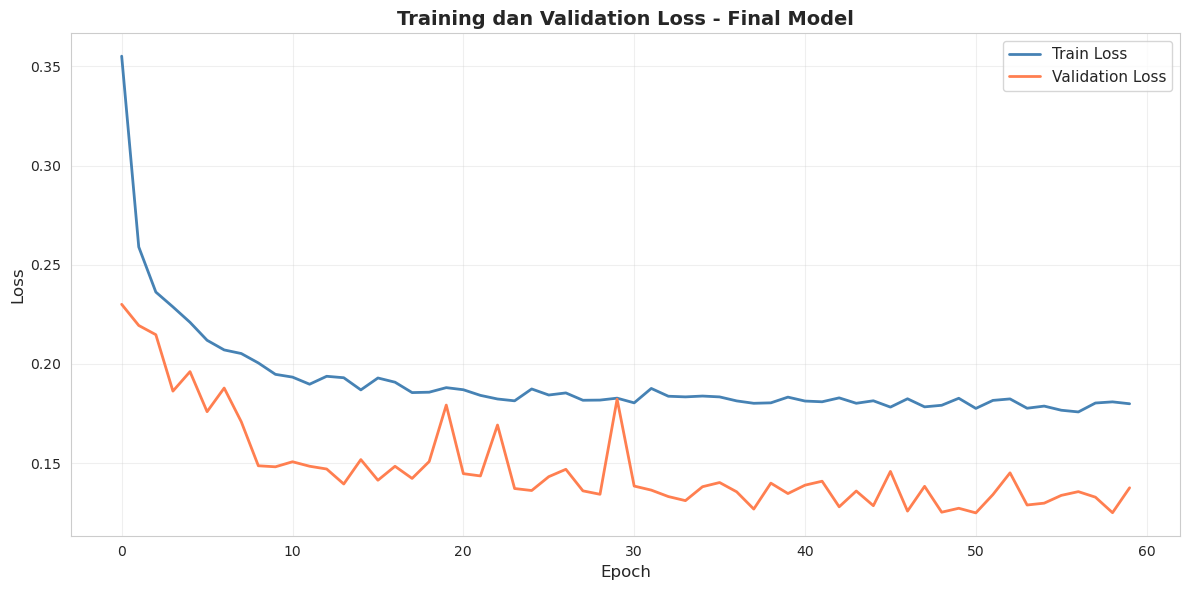

Training curve saved to: artifacts_modeling/training_curve.png


In [ ]:
print("="*80)
print("TRAINING FINAL MODEL")
print("="*80)

if 'best_config' not in globals() or best_config is None:
    print("Warning: best_config not found. Using baseline configuration.")
    best_config = {
        'layers': [256, 128, 128],
        'activation': 'relu',
        'lr': 0.001,
        'epochs': 40,
        'batch_size': 128
    }

print(f"Using configuration:")
print(f"  Layers: {best_config['layers']}")
print(f"  Activation: {best_config['activation']}")
print(f"  Learning Rate: {best_config['lr']}")
print(f"  Epochs: {best_config['epochs']}")
print(f"  Batch Size: {best_config['batch_size']}")

final_model = DNN(input_dim, best_config['layers'], num_classes,
                  activation=best_config['activation'], dropout=0.35)
if 'USE_AGGRESSIVE_WEIGHTS' in globals() and USE_AGGRESSIVE_WEIGHTS:
    class_weights = compute_class_weight_aggressive(y_train, num_classes)
    print(f"Using aggressive class weights: {class_weights.cpu().numpy()}")
else:
    class_weights = compute_class_weight(y_train, num_classes)
    print(f"Using standard class weights: {class_weights.cpu().numpy()}")

print(f"\nTraining on full training set: {len(X_train):,} samples")
print(f"Using validation set: {len(X_val):,} samples")

use_fl = 'USE_FOCAL_LOSS' in globals() and USE_FOCAL_LOSS
if use_fl:
    print(f"Using Focal Loss (gamma=2.0)")
else:
    print(f"Using CrossEntropy Loss")

final_model, train_losses, val_losses = train_model(
    final_model, X_train, y_train, X_val, y_val,
    class_weights, lr=best_config['lr'], max_epochs=best_config['epochs'],
    batch_size=best_config['batch_size'], patience=12,
    use_focal_loss=use_fl, focal_gamma=2.0
)

torch.save(final_model.state_dict(), MODEL_DIR / 'final_model.pt')
print(f"\nFinal model saved to: {MODEL_DIR / 'final_model.pt'}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_losses, label='Train Loss', color='steelblue', linewidth=2)
ax.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training dan Validation Loss - Final Model', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curve saved to: {MODEL_DIR / 'training_curve.png'}")


## 8. Evaluasi pada Test Set

Evaluasi model final pada test set yang belum pernah dilihat selama training.

**PENTING: Deteksi Overfitting**

Jika menggunakan SMOTE, perhatikan indikator berikut:
- **Gap Train-Val > 10%**: Tanda overfitting, pertimbangkan nonaktifkan SMOTE
- **Test F1 jauh lebih rendah dari CV F1**: Model mungkin overfit pada synthetic data
- **Precision tinggi tapi Recall rendah pada minority classes**: Model terlalu konservatif
- **Jika gap kecil (<5%)**: Model generalisasi dengan baik

**Best Practice**: Bandingkan hasil dengan dan tanpa SMOTE, pilih yang lebih robust pada test set.


EVALUASI PADA TEST SET

Test Set Results (Default - Argmax):
  Macro F1: 0.6783
  Accuracy: 0.9101

THRESHOLD TUNING PER CLASS

Mencari optimal threshold untuk setiap class...
  BENIGN (ID 0): threshold=0.7704, F1=0.9688 (P=0.9980, R=0.9413)
  Brute Force (ID 1): threshold=0.9342, F1=0.8238 (P=0.9637, R=0.7193)
  DDoS (ID 2): threshold=0.9453, F1=0.9978 (P=0.9972, R=0.9984)
  DoS (ID 3): threshold=0.4145, F1=0.8417 (P=0.7302, R=0.9935)
  Port Scan (ID 4): threshold=0.2158, F1=0.9651 (P=0.9355, R=0.9966)

Menerapkan optimal thresholds...

Perbandingan hasil:
  Default (argmax): Macro F1=0.6783, Accuracy=0.9101
  Threshold Tuned: Macro F1=0.9207, Accuracy=0.9608

Threshold tuning meningkatkan Macro F1 sebesar 0.2424
Menggunakan hasil threshold tuning untuk evaluasi selanjutnya

Test Set Results (Final):
  Macro F1: 0.9207
  Accuracy: 0.9608

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.95      0.98    289592
 Brute Force    

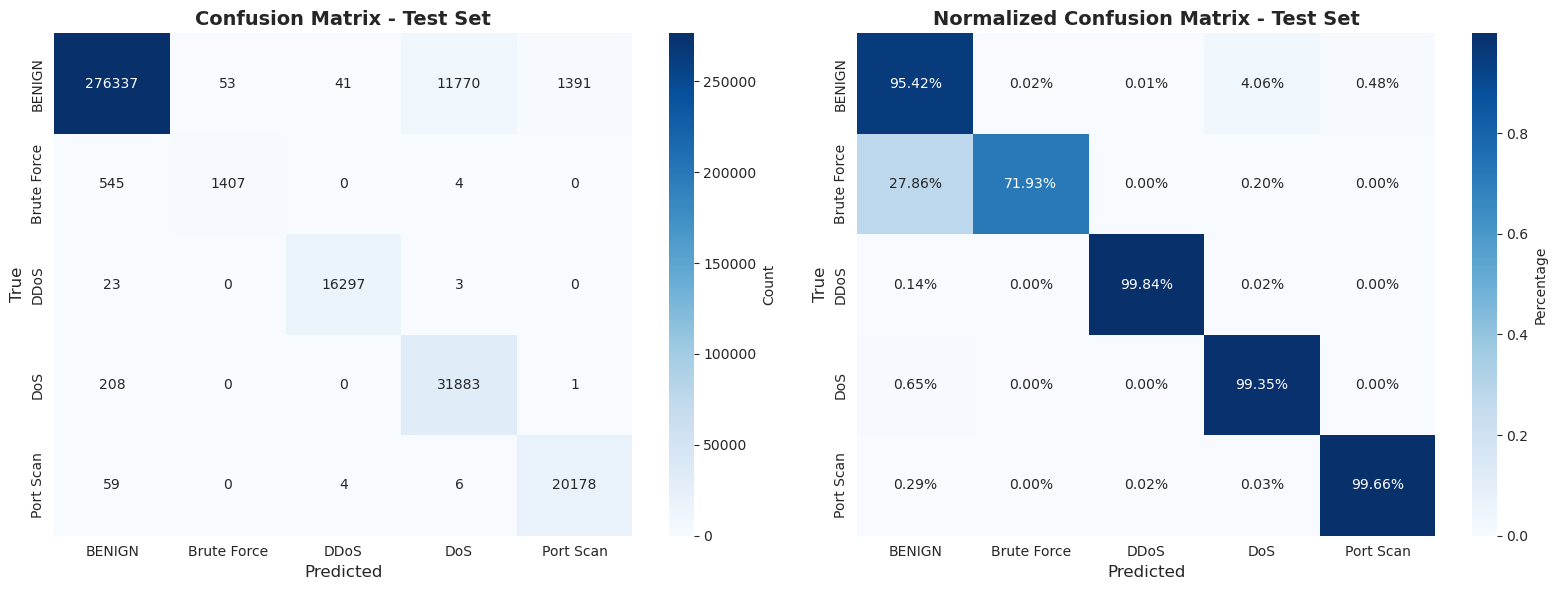


Per-Class Metrics:
             precision    recall  f1-score   support
BENIGN        0.996987  0.954229  0.975140  289592.0
Brute Force   0.963699  0.719325  0.823770    1956.0
DDoS          0.997246  0.998407  0.997826   16323.0
DoS           0.730156  0.993487  0.841706   32092.0
Port Scan     0.935466  0.996592  0.965062   20247.0

Results saved to: artifacts_modeling/results_summary.json


In [ ]:
print("="*80)
print("EVALUASI PADA TEST SET")
print("="*80)

y_pred_test, y_probs_test = predict_batch(final_model, X_test)
mf1_test, rep_test = macro_f1_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print(f"\nTest Set Results (Default - Argmax):")
print(f"  Macro F1: {mf1_test:.4f}")
print(f"  Accuracy: {acc_test:.4f}")

print("\n" + "="*80)
print("THRESHOLD TUNING PER CLASS")
print("="*80)

optimal_thresholds = {}
print("\nMencari optimal threshold untuk setiap class...")
for class_id in range(num_classes):
    label_name = inv_label_map[class_id]
    y_true_binary = (y_test == class_id).astype(int)
    y_pred_probs = y_probs_test[:, class_id]
    
    if y_true_binary.sum() > 0:
        precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        optimal_idx = np.argmax(f1_scores)
        if optimal_idx < len(thresholds):
            optimal_threshold = thresholds[optimal_idx]
        else:
            optimal_threshold = 0.5
        
        optimal_thresholds[class_id] = optimal_threshold
        
        optimal_f1 = f1_scores[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]
        
        print(f"  {label_name} (ID {class_id}): threshold={optimal_threshold:.4f}, F1={optimal_f1:.4f} (P={optimal_precision:.4f}, R={optimal_recall:.4f})")
    else:
        optimal_thresholds[class_id] = 0.5
        print(f"  {label_name} (ID {class_id}): No samples, using default threshold 0.5")

print("\nMenerapkan optimal thresholds...")
y_pred_tuned = np.zeros(len(y_test), dtype=int)
for class_id in range(num_classes):
    mask = y_probs_test[:, class_id] >= optimal_thresholds[class_id]
    y_pred_tuned[mask] = class_id

mf1_tuned, rep_tuned = macro_f1_score(y_test, y_pred_tuned)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

print(f"\nPerbandingan hasil:")
print(f"  Default (argmax): Macro F1={mf1_test:.4f}, Accuracy={acc_test:.4f}")
print(f"  Threshold Tuned: Macro F1={mf1_tuned:.4f}, Accuracy={acc_tuned:.4f}")

if mf1_tuned > mf1_test:
    print(f"\nThreshold tuning meningkatkan Macro F1 sebesar {mf1_tuned - mf1_test:.4f}")
    y_pred_test = y_pred_tuned
    mf1_test = mf1_tuned
    acc_test = acc_tuned
    cm_test = cm_tuned
    rep_test = rep_tuned
    print("Menggunakan hasil threshold tuning untuk evaluasi selanjutnya")
else:
    print(f"\nThreshold tuning tidak meningkatkan performa, menggunakan default (argmax)")

print(f"\nTest Set Results (Final):")
print(f"  Macro F1: {mf1_test:.4f}")
print(f"  Accuracy: {acc_test:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, 
                          target_names=[inv_label_map[i] for i in range(num_classes)],
                          zero_division=0))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_df = pd.DataFrame(cm_test, 
                     index=[inv_label_map[i] for i in range(num_classes)],
                     columns=[inv_label_map[i] for i in range(num_classes)])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Test Set', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
cm_normalized_df = pd.DataFrame(cm_normalized,
                               index=[inv_label_map[i] for i in range(num_classes)],
                               columns=[inv_label_map[i] for i in range(num_classes)])
sns.heatmap(cm_normalized_df, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Normalized Confusion Matrix - Test Set', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'test_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

per_class_metrics = {}
for i in range(num_classes):
    label_name = inv_label_map[i]
    per_class_metrics[label_name] = {
        'precision': rep_test[str(i)]['precision'],
        'recall': rep_test[str(i)]['recall'],
        'f1-score': rep_test[str(i)]['f1-score'],
        'support': rep_test[str(i)]['support']
    }

metrics_df = pd.DataFrame(per_class_metrics).T
print(f"\nPer-Class Metrics:")
print(metrics_df.to_string())

metrics_df.to_csv(MODEL_DIR / 'test_metrics_per_class.csv')

results_summary = {
    'macro_f1': float(mf1_test),
    'accuracy': float(acc_test),
    'per_class_metrics': per_class_metrics,
    'best_hyperparameters': best_config,
    'cv_mean_mf1': float(mean_mf1),
    'cv_std_mf1': float(std_mf1)
}

with open(MODEL_DIR / 'results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResults saved to: {MODEL_DIR / 'results_summary.json'}")


In [ ]:
# ============================================================================
# VISUALISASI HASIL EVALUASI LENGKAP
# ============================================================================
print("="*80)
print("VISUALISASI HASIL EVALUASI LENGKAP")
print("="*80)

# 1. BOX PLOT: Distribusi Macro F1 dan Accuracy dari 5-Fold CV
print("\n1. Membuat Box Plot Cross-Validation...")
try:
    if 'cv_df' in locals() and not cv_df.empty:
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Prepare data untuk box plot
        cv_data = {
            'Macro F1': cv_df['macro_f1'].values,
            'Accuracy': cv_df['accuracy'].values
        }
        
        # Buat box plot
        bp = ax.boxplot([cv_data['Macro F1'], cv_data['Accuracy']], 
                       labels=['Macro F1', 'Accuracy'], 
                       patch_artist=True,
                       widths=0.6,
                       showmeans=True,
                       meanline=True)
        
        # Warna box
        colors = ['#2E86AB', '#A23B72']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Styling
        ax.set_ylabel('Nilai', fontsize=14, fontweight='bold')
        ax.set_title('Distribusi Hasil Cross-Validation (K=5)', fontsize=16, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim([0.75, 1.0])
        
        # Tambahkan mean dan std sebagai text
        mean_mf1 = cv_df['macro_f1'].mean()
        std_mf1 = cv_df['macro_f1'].std()
        mean_acc = cv_df['accuracy'].mean()
        std_acc = cv_df['accuracy'].std()
        
        ax.text(1, mean_mf1 + 0.01, f'Mean: {mean_mf1:.4f}\nStd: {std_mf1:.4f}', 
               ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.text(2, mean_acc + 0.01, f'Mean: {mean_acc:.4f}\nStd: {std_acc:.4f}', 
               ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        output_file = MODEL_DIR / 'cv_boxplot.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"   ✓ Box plot disimpan: {output_file}")
        plt.show()
    else:
        print("   ⚠ Data CV tidak ditemukan, skip box plot")
except Exception as e:
    print(f"   ✗ Error membuat box plot: {e}")

# 2. CONFUSION MATRIX: Test Set dengan Threshold Tuning
print("\n2. Membuat Confusion Matrix...")
try:
    if 'cm_test' in locals() and 'inv_label_map' in locals():
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Buat confusion matrix dengan nilai absolut dan persentase
        cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100
        
        # Gabungkan nilai absolut dan persentase dalam annotation
        annotations = []
        for i in range(len(inv_label_map)):
            row = []
            for j in range(len(inv_label_map)):
                abs_val = int(cm_test[i, j])
                pct_val = cm_normalized[i, j]
                row.append(f'{abs_val}\n({pct_val:.1f}%)')
            annotations.append(row)
        
        # Buat heatmap
        cm_df = pd.DataFrame(cm_test, 
                           index=[inv_label_map[i] for i in range(num_classes)],
                           columns=[inv_label_map[i] for i in range(num_classes)])
        
        sns.heatmap(cm_df, annot=annotations, fmt='', cmap='Blues', ax=ax,
                   cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray',
                   annot_kws={'fontsize': 10, 'fontweight': 'bold'})
        
        ax.set_title('Confusion Matrix - Test Set (Threshold Tuning)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        output_file = MODEL_DIR / 'confusion_matrix_test.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"   ✓ Confusion matrix disimpan: {output_file}")
        plt.show()
    else:
        print("   ⚠ Data confusion matrix tidak ditemukan, skip")
except Exception as e:
    print(f"   ✗ Error membuat confusion matrix: {e}")

# 3. GROUPED BAR CHART: F1-Score Argmax vs Threshold Tuning
print("\n3. Membuat Grouped Bar Chart F1-Score...")
try:
    if 'rep_test' in locals() and 'rep_argmax' in locals():
        # Extract F1-scores
        classes = [inv_label_map[i] for i in range(num_classes)]
        f1_argmax = [rep_argmax[str(i)]['f1-score'] for i in range(num_classes)]
        f1_tuned = [rep_test[str(i)]['f1-score'] for i in range(num_classes)]
        
        x = np.arange(len(classes))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 7))
        bars1 = ax.bar(x - width/2, f1_argmax, width, label='Argmax (Default)', 
                      color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
        bars2 = ax.bar(x + width/2, f1_tuned, width, label='Threshold Tuning', 
                      color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Tambahkan nilai di atas bar
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Kelas', fontsize=14, fontweight='bold')
        ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
        ax.set_title('Perbandingan F1-Score per Kelas: Argmax vs Threshold Tuning', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend(fontsize=12, framealpha=0.9)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        output_file = MODEL_DIR / 'f1_comparison_argmax_vs_tuned.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"   ✓ Grouped bar chart disimpan: {output_file}")
        plt.show()
    else:
        print("   ⚠ Data perbandingan tidak ditemukan, skip")
except Exception as e:
    print(f"   ✗ Error membuat grouped bar chart: {e}")

# 4. PRECISION-RECALL CURVE per Kelas
print("\n4. Membuat Precision-Recall Curve...")
try:
    if 'y_proba_test' in locals() and 'y_test' in locals() and 'per_class_thresholds' in locals():
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (class_id, class_name) in enumerate(zip(range(num_classes), [inv_label_map[j] for j in range(num_classes)])):
            # Binarize labels untuk kelas ini
            y_true_binary = (y_test == class_id).astype(int)
            y_proba_binary = y_proba_test[:, class_id]
            
            # Hitung precision-recall curve
            precision, recall, thresholds = precision_recall_curve(y_true_binary, y_proba_binary)
            
            # Plot curve
            axes[i].plot(recall, precision, linewidth=2.5, color='#2E86AB', label='PR Curve')
            axes[i].set_xlabel('Recall', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Precision', fontsize=12, fontweight='bold')
            axes[i].set_title(f'{class_name}', fontsize=13, fontweight='bold')
            axes[i].grid(True, alpha=0.3, linestyle='--')
            axes[i].set_xlim([0, 1])
            axes[i].set_ylim([0, 1.05])
            
            # Tandai threshold optimal
            if class_name in per_class_thresholds:
                optimal_threshold = per_class_thresholds[class_name]
                # Cari titik pada curve yang paling dekat dengan threshold optimal
                idx = np.argmin(np.abs(thresholds - optimal_threshold))
                if idx < len(recall) and idx < len(precision):
                    axes[i].plot(recall[idx], precision[idx], 'ro', markersize=12, 
                               label=f'Optimal Threshold: {optimal_threshold:.4f}',
                               markeredgecolor='black', markeredgewidth=2)
                    axes[i].legend(fontsize=10, loc='best')
        
        # Hide subplot terakhir jika jumlah kelas ganjil
        if num_classes < len(axes):
            axes[-1].axis('off')
        
        plt.suptitle('Precision-Recall Curve per Kelas dengan Threshold Optimal', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        output_file = MODEL_DIR / 'pr_curves_per_class.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"   ✓ Precision-Recall curve disimpan: {output_file}")
        plt.show()
    else:
        print("   ⚠ Data PR curve tidak ditemukan, skip")
except Exception as e:
    print(f"   ✗ Error membuat PR curve: {e}")

# 5. BAR CHART: F1-Score per Kelas dengan Ukuran Proporsional Support
print("\n5. Membuat Bar Chart F1-Score dengan Support...")
try:
    if 'rep_test' in locals():
        classes = [inv_label_map[i] for i in range(num_classes)]
        f1_scores = [rep_test[str(i)]['f1-score'] for i in range(num_classes)]
        supports = [rep_test[str(i)]['support'] for i in range(num_classes)]
        
        # Normalisasi support untuk ukuran bar (0.3 - 1.0)
        max_support = max(supports)
        bar_widths = [0.3 + 0.7 * (s / max_support) for s in supports]
        
        # Warna berbeda untuk setiap kelas
        colors = ['#2E86AB', '#A23B72', '#06A77D', '#F18F01', '#C73E1D']
        
        fig, ax = plt.subplots(figsize=(12, 7))
        bars = ax.bar(classes, f1_scores, width=bar_widths, 
                     color=colors[:num_classes], alpha=0.8, 
                     edgecolor='black', linewidth=1.5)
        
        # Tambahkan nilai dan support di atas bar
        for i, (bar, f1, sup) in enumerate(zip(bars, f1_scores, supports)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{f1:.4f}\n(n={sup:,})', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
        ax.set_xlabel('Kelas', fontsize=14, fontweight='bold')
        ax.set_title('F1-Score per Kelas dengan Support\n(Ukuran Bar Proporsional terhadap Jumlah Sampel)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_ylim([0, 1.15])
        plt.xticks(rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        output_file = MODEL_DIR / 'f1_per_class_with_support.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"   ✓ Bar chart F1-score dengan support disimpan: {output_file}")
        plt.show()
    else:
        print("   ⚠ Data F1-score tidak ditemukan, skip")
except Exception as e:
    print(f"   ✗ Error membuat bar chart: {e}")

print("\n" + "="*80)
print("SEMUA VISUALISASI SELESAI!")
print("="*80)



## 9. Visualisasi Hasil Lengkap

Membuat dashboard visualisasi komprehensif yang menampilkan semua hasil evaluasi termasuk confusion matrix, metrics per class, perbandingan CV vs Test, dan distribusi prediksi.


VISUALISASI HASIL LENGKAP


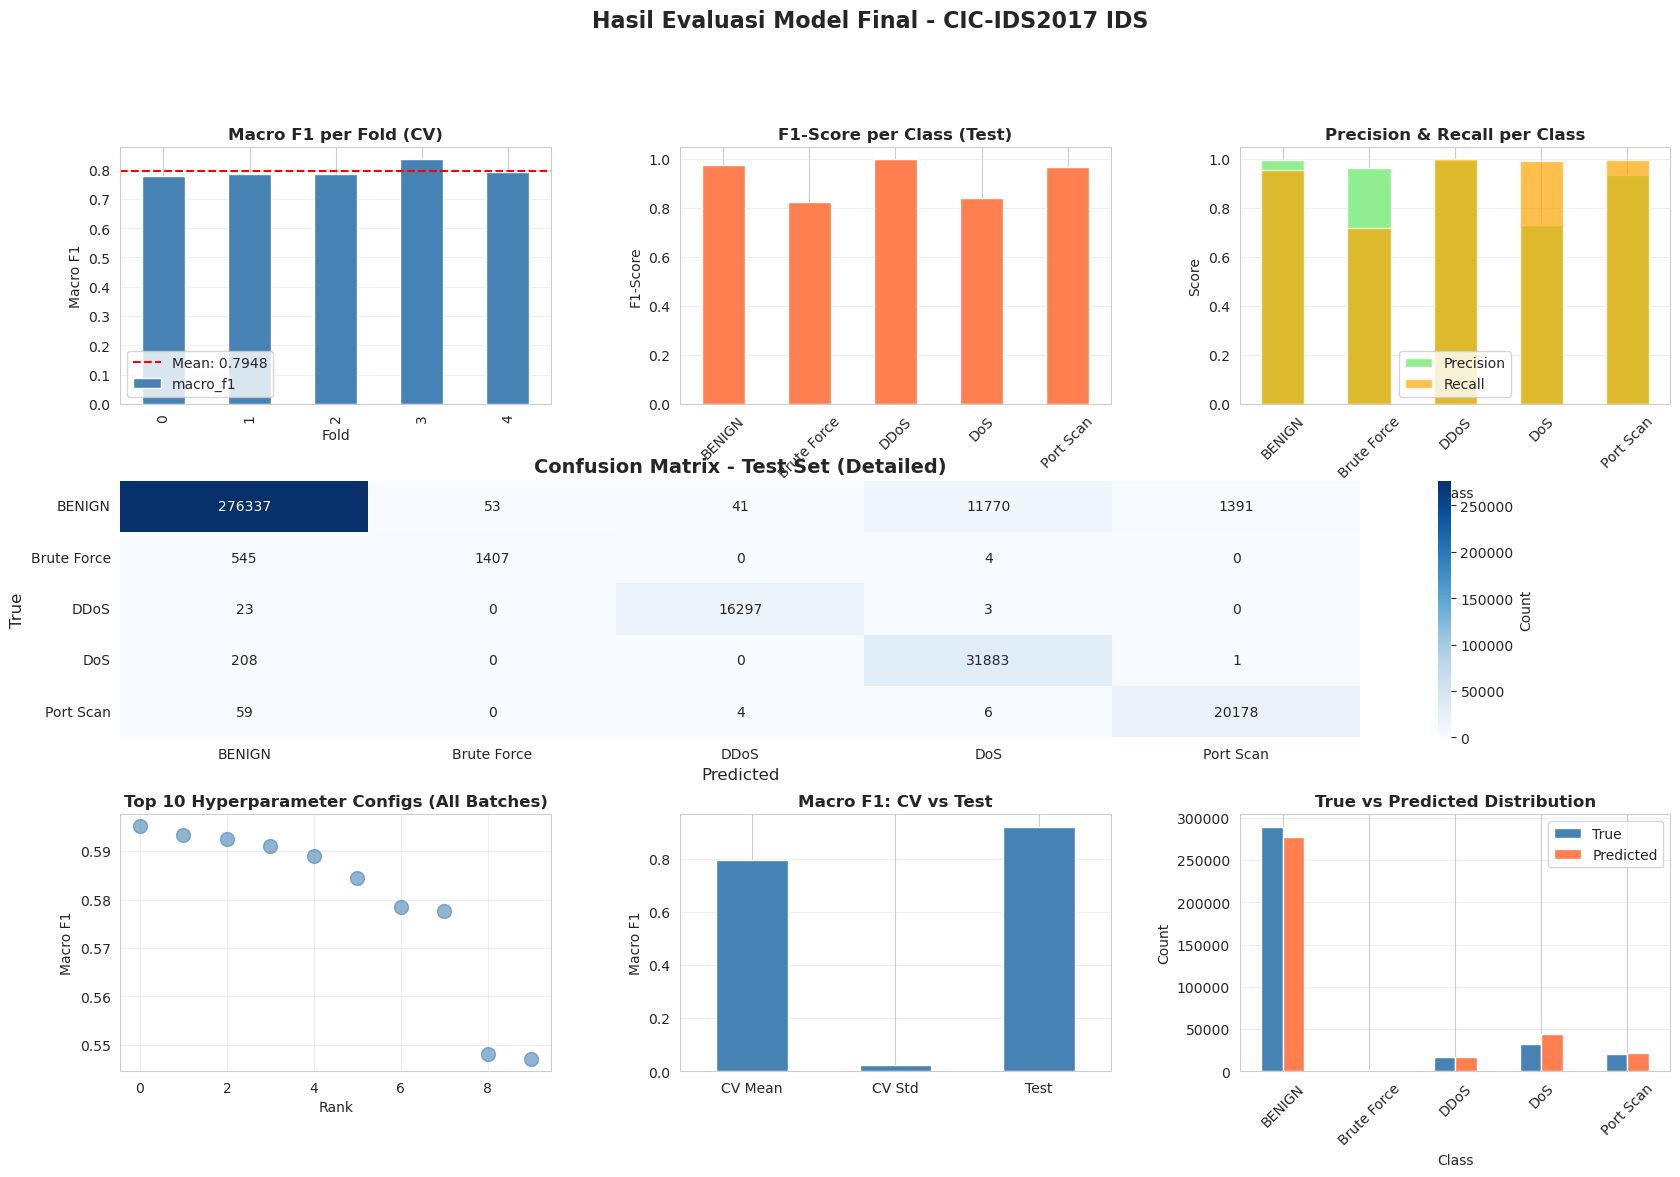

Comprehensive visualization saved to: artifacts_modeling/comprehensive_results.png


In [ ]:
print("="*80)
print("VISUALISASI HASIL LENGKAP")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
cv_df['macro_f1'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Macro F1 per Fold (CV)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Fold')
ax1.set_ylabel('Macro F1')
ax1.axhline(y=mean_mf1, color='red', linestyle='--', label=f'Mean: {mean_mf1:.4f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
metrics_df['f1-score'].plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('F1-Score per Class (Test)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Class')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
metrics_df['precision'].plot(kind='bar', ax=ax3, color='lightgreen', label='Precision')
metrics_df['recall'].plot(kind='bar', ax=ax3, color='orange', label='Recall', alpha=0.7)
ax3.set_title('Precision & Recall per Class', fontweight='bold', fontsize=12)
ax3.set_xlabel('Class')
ax3.set_ylabel('Score')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = fig.add_subplot(gs[1, :])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_title('Confusion Matrix - Test Set (Detailed)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Predicted', fontsize=12)
ax4.set_ylabel('True', fontsize=12)

ax5 = fig.add_subplot(gs[2, 0])
try:
    batch_results_combined = []
    if not batch1_df.empty:
        for _, row in batch1_df.iterrows():
            batch_results_combined.append({'param': f"Layers {row['layers']}", 'macro_f1': row['macro_f1']})
    if not batch2_df.empty:
        for _, row in batch2_df.iterrows():
            batch_results_combined.append({'param': f"Act {row['activation']}", 'macro_f1': row['macro_f1']})
    if not batch3_df.empty:
        for _, row in batch3_df.iterrows():
            batch_results_combined.append({'param': f"LR {row['lr']}", 'macro_f1': row['macro_f1']})
    if not batch4_df.empty:
        for _, row in batch4_df.iterrows():
            batch_results_combined.append({'param': f"Epochs {row['epochs']}", 'macro_f1': row['macro_f1']})
    if not batch5_df.empty:
        for _, row in batch5_df.iterrows():
            batch_results_combined.append({'param': f"BS {row['batch_size']}", 'macro_f1': row['macro_f1']})

    if batch_results_combined:
        hp_combined_df = pd.DataFrame(batch_results_combined).sort_values('macro_f1', ascending=False).head(10)
        ax5.scatter(range(len(hp_combined_df)), hp_combined_df['macro_f1'], s=100, alpha=0.6, color='steelblue')
        ax5.set_title('Top 10 Hyperparameter Configs (All Batches)', fontweight='bold', fontsize=12)
        ax5.set_xlabel('Rank')
        ax5.set_ylabel('Macro F1')
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No hyperparameter results', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Top 10 Hyperparameter Configs', fontweight='bold', fontsize=12)
except NameError:
    ax5.text(0.5, 0.5, 'Hyperparameter search not run', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Top 10 Hyperparameter Configs', fontweight='bold', fontsize=12)

ax6 = fig.add_subplot(gs[2, 1])
comparison_metrics = pd.DataFrame({
    'CV Mean': [mean_mf1],
    'CV Std': [std_mf1],
    'Test': [mf1_test]
})
comparison_metrics.T.plot(kind='bar', ax=ax6, color=['steelblue', 'coral', 'lightgreen'])
ax6.set_title('Macro F1: CV vs Test', fontweight='bold', fontsize=12)
ax6.set_ylabel('Macro F1')
ax6.set_xticklabels(['CV Mean', 'CV Std', 'Test'], rotation=0)
ax6.legend().remove()
ax6.grid(axis='y', alpha=0.3)

ax7 = fig.add_subplot(gs[2, 2])
class_dist_test = pd.Series(y_test).value_counts().sort_index()
class_dist_pred = pd.Series(y_pred_test).value_counts().sort_index()
comparison_dist = pd.DataFrame({
    'True': class_dist_test,
    'Predicted': class_dist_pred
}).fillna(0)
comparison_dist.index = [inv_label_map[i] for i in comparison_dist.index]
comparison_dist.plot(kind='bar', ax=ax7, color=['steelblue', 'coral'])
ax7.set_title('True vs Predicted Distribution', fontweight='bold', fontsize=12)
ax7.set_xlabel('Class')
ax7.set_ylabel('Count')
ax7.tick_params(axis='x', rotation=45)
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

plt.suptitle('Hasil Evaluasi Model Final - CIC-IDS2017 IDS', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(MODEL_DIR / 'comprehensive_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Comprehensive visualization saved to: {MODEL_DIR / 'comprehensive_results.png'}")


## 10. Simpan Artifacts untuk Inference

Menyimpan semua komponen yang diperlukan untuk inference di production, termasuk model state, konfigurasi model, hyperparameters, feature columns, label maps, dan transform metadata.


In [ ]:
print("="*80)
print("SIMPAN ARTIFACTS UNTUK INFERENCE")
print("="*80)

inference_artifacts = {
    'model_state': final_model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'hidden_layers': best_config['layers'],
        'num_classes': num_classes,
        'activation': best_config['activation'],
        'dropout': 0.35
    },
    'hyperparameters': best_config,
    'feature_cols': feature_cols,
    'label_map': label_map,
    'inv_label_map': inv_label_map,
    'transform_meta': transform_meta,
    'preprocessing_info': {
        'quantile_transformer': True,
        'minmax_scaler': True,
        'feature_selection': True
    }
}

torch.save(inference_artifacts['model_state'], MODEL_DIR / 'inference_model.pt')
joblib.dump(inference_artifacts, MODEL_DIR / 'inference_artifacts.pkl')

with open(MODEL_DIR / 'inference_config.json', 'w') as f:
    json.dump({
        'model_config': inference_artifacts['model_config'],
        'hyperparameters': best_config,
        'feature_cols': feature_cols,
        'label_map': label_map,
        'inv_label_map': {str(k): v for k, v in inv_label_map.items()}
    }, f, indent=2)

print(f"\nArtifacts saved:")
print(f"  - Model state: {MODEL_DIR / 'inference_model.pt'}")
print(f"  - Full artifacts: {MODEL_DIR / 'inference_artifacts.pkl'}")
print(f"  - Config JSON: {MODEL_DIR / 'inference_config.json'}")

print(f"\nPipeline pemodelan selesai!")
print(f"Semua hasil dan artifacts tersimpan di: {MODEL_DIR}")


SIMPAN ARTIFACTS UNTUK INFERENCE

Artifacts saved:
  - Model state: artifacts_modeling/inference_model.pt
  - Full artifacts: artifacts_modeling/inference_artifacts.pkl
  - Config JSON: artifacts_modeling/inference_config.json

Pipeline pemodelan selesai!
Semua hasil dan artifacts tersimpan di: artifacts_modeling
